(HW7)=
# HW7

**Deadline (hard only!)**: 24.04.2024 11:59 (GMT+5).

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

     --------------------------------------- 12.1/12.1 MB 27.2 kB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 42.4 kB/s eta 0:00:00
     ------------------------------------- 178.9/178.9 kB 26.1 kB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 27.9 kB/s eta 0:00:00
     ------------------------------------- 313.2/313.2 kB 30.0 kB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 28.3 kB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.2.0
    Uninstalling Pillow-7.2.0:
      Successfully uninstalled Pillow-7.2.0


## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* logistic regression, 86% (**1 point**)
* k-nearest neigbors, 88% (**1 point**)
* MLP, 91% (**1 point**)
* CNN, 92% (**1.5 points**)
* overall comparison of models, including some graphs (e.g, bar plot) (**0.5 points**)

### Important notes

* The total time of execution of all cells must not exceed $10$ minutes
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Measure and print train and test accuracy

    4. Make predictions on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
    
    7. Try different hyperparameters, plot graphs of accuracy vs most important parameters

## Load `notmnist` dataset

In [18]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
Wall time: 54.7 s


Size of train and test datasets:

In [19]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1405, 1404, 1405, 1404, 1404, 1404, 1404, 1404],
       dtype=int64))

## Visualize some data

In [13]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

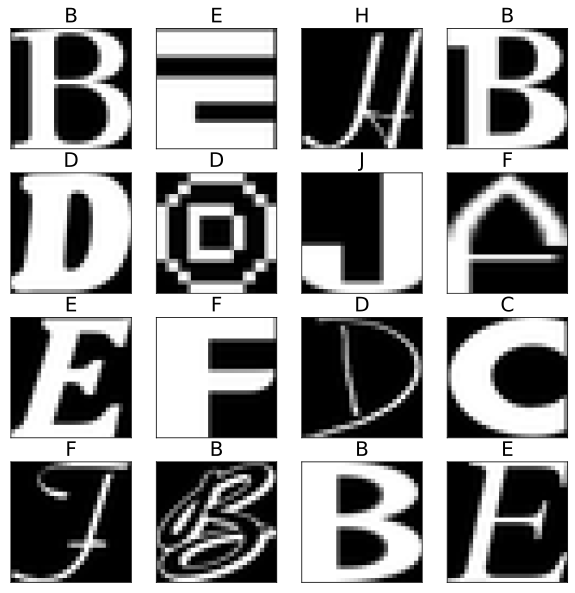

In [14]:
plot_letters(X_train, y_train, random_state=912)

## Logistic regression

**Hyperparameters**:
* regularization type (`penalty`)
* regularization constant ($C$)
* `max_iter`

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 37.7min finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 37.7min remaining:    0.0s


Лучшие гиперпараметры: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 0.005994842503189409}
Точность обучения: 0.90
Точность тестирования: 0.88


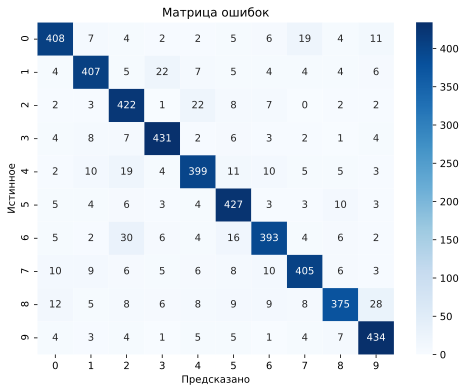

Wall time: 38min 43s


In [23]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns



param_grid = {
    'penalty': ['l2', 'none'], 
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000]
}

log_reg = LogisticRegression()
random_search = RandomizedSearchCV(log_reg, param_grid, n_iter=10, cv=3, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)


best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Лучшие гиперпараметры:", best_params)



y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)


train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Точность обучения: {train_accuracy:.2f}")
print(f"Точность тестирования: {test_accuracy:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Истинное')
plt.title('Матрица ошибок')
plt.show()


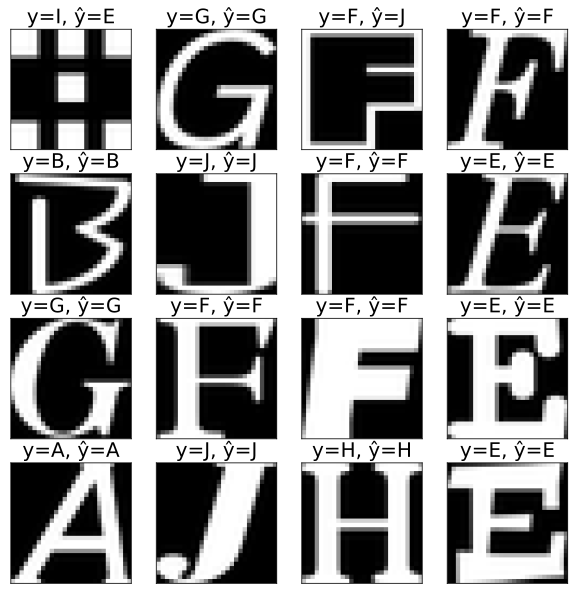

In [24]:
plot_letters(X_test, y_test, y_pred_test)

## kNN

**Hyperparameters**:
* `n_neigbors`
* `metric`

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 11.3min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 11.4min finished


Лучшие гиперпараметры: {'metric': 'euclidean', 'n_neighbors': 7}
Точность обучения: 0.91
Точность тестирования: 0.87


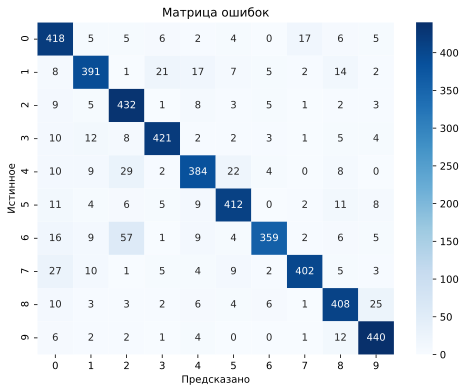

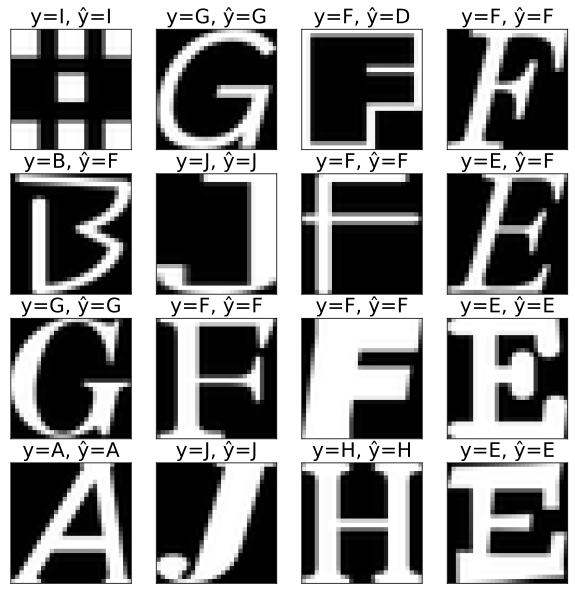

Wall time: 19min 52s


In [26]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns



param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan']  
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Лучшие гиперпараметры:", best_params)


y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Точность обучения: {train_accuracy:.2f}")
print(f"Точность тестирования: {test_accuracy:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Истинное')
plt.title('Матрица ошибок')
plt.show()

plot_letters(X_test, y_test, y_pred_test)

## MLP

**Hyperparameters**:
* number of layers
* width of layers
* activation function

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 24.1min finished


Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'max_iter': 1000, 'solver': 'adam'}
Точность обучения: 1.00
Точность тестирования: 0.91


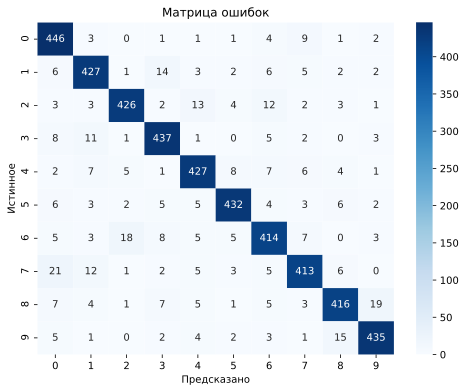

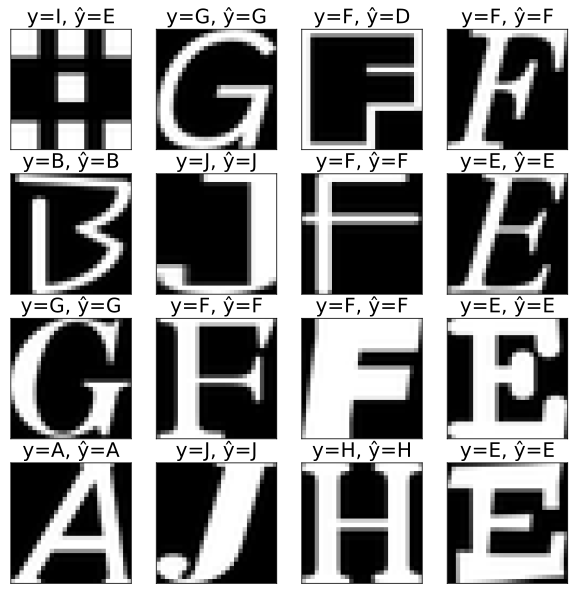

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns




param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  
    'activation': ['tanh', 'relu'],  
    'max_iter': [1000],  
    'alpha': [0.0001, 0.001, 0.01],  
    'solver': ['adam'],  
}

mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Лучшие гиперпараметры:", best_params)


y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Точность обучения: {train_accuracy:.2f}")
print(f"Точность тестирования: {test_accuracy:.2f}")


conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Истинное')
plt.title('Матрица ошибок')
plt.show()


plot_letters(X_test, y_test, y_pred_test)

## CNN

**Hyperparameters**:
* number of convolutional layers
* number of dense layers
* activation function

In [ ]:
%%time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix



X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


model = Sequential([
    Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Точность обучения: {train_acc:.2f}")
print(f"Точность тестирования: {test_acc:.2f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



plot_letters(X_test, y_test, y_pred_classes)

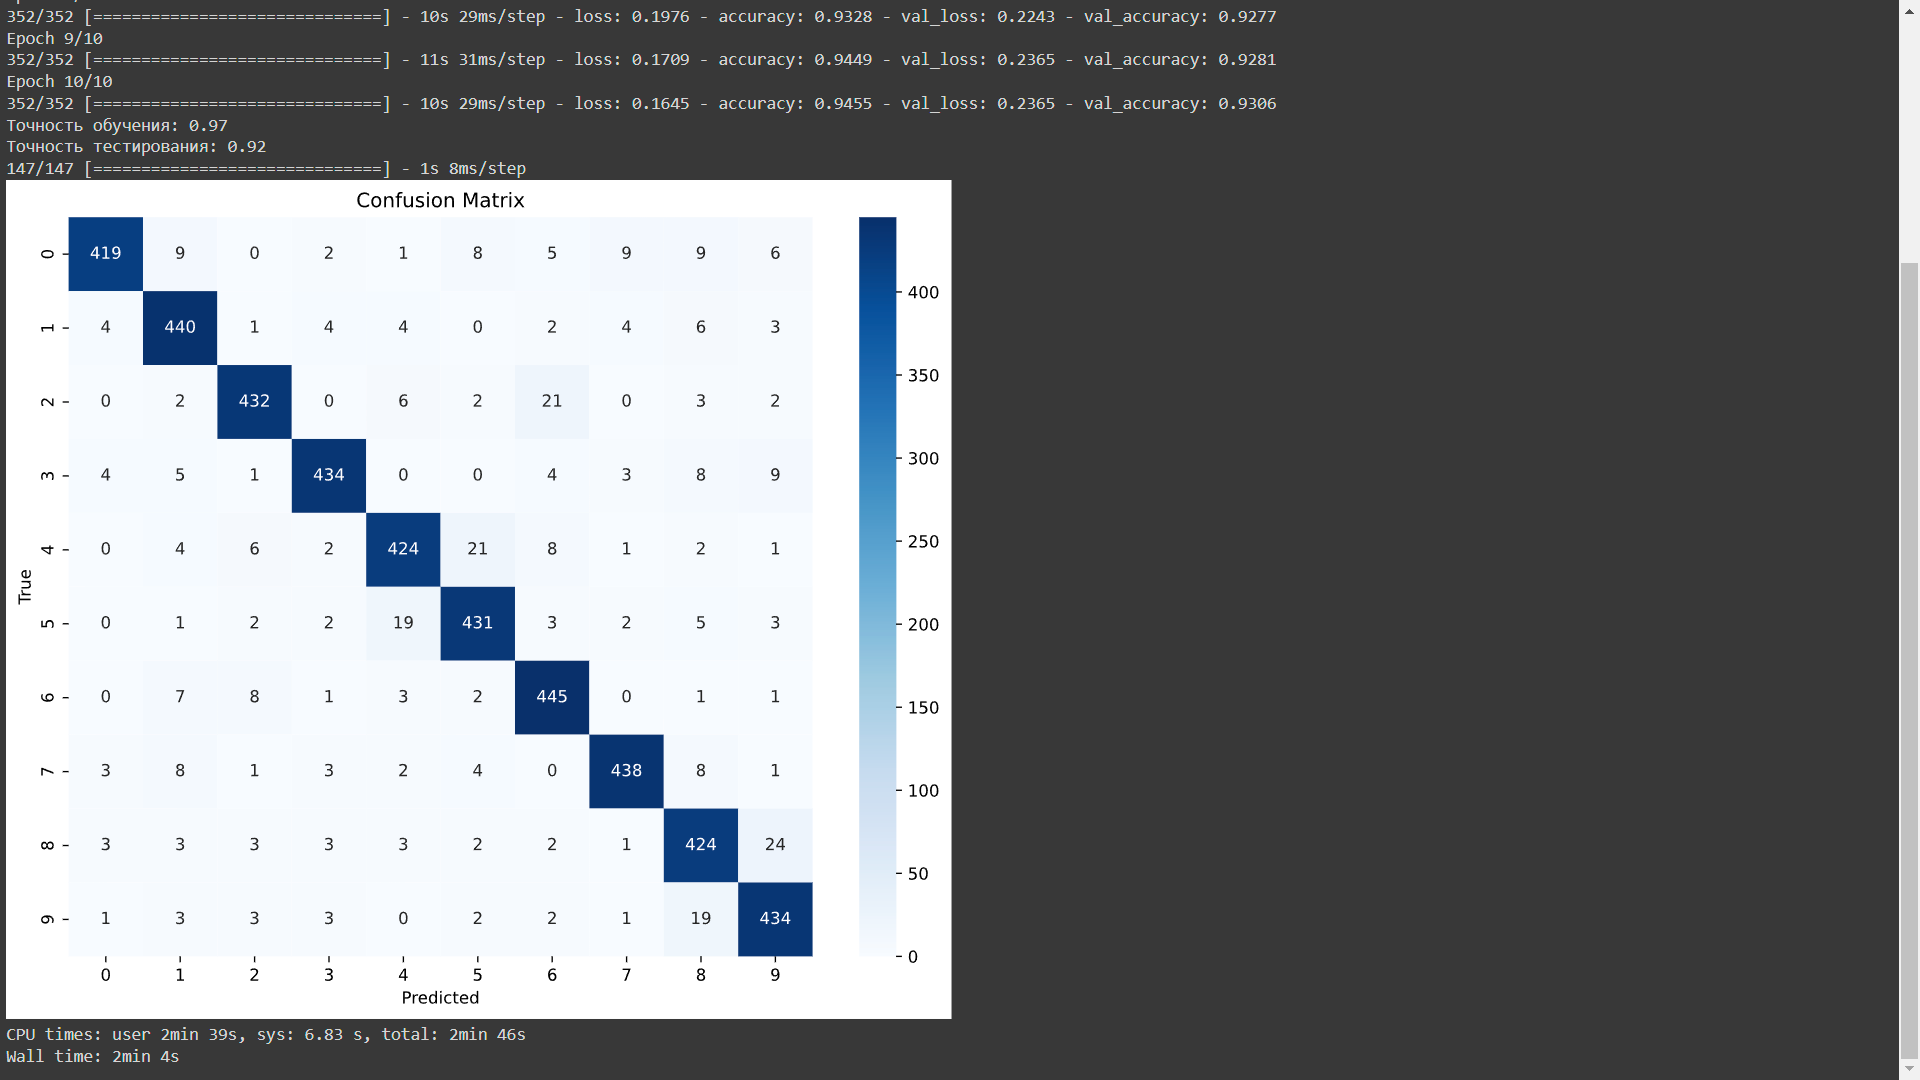


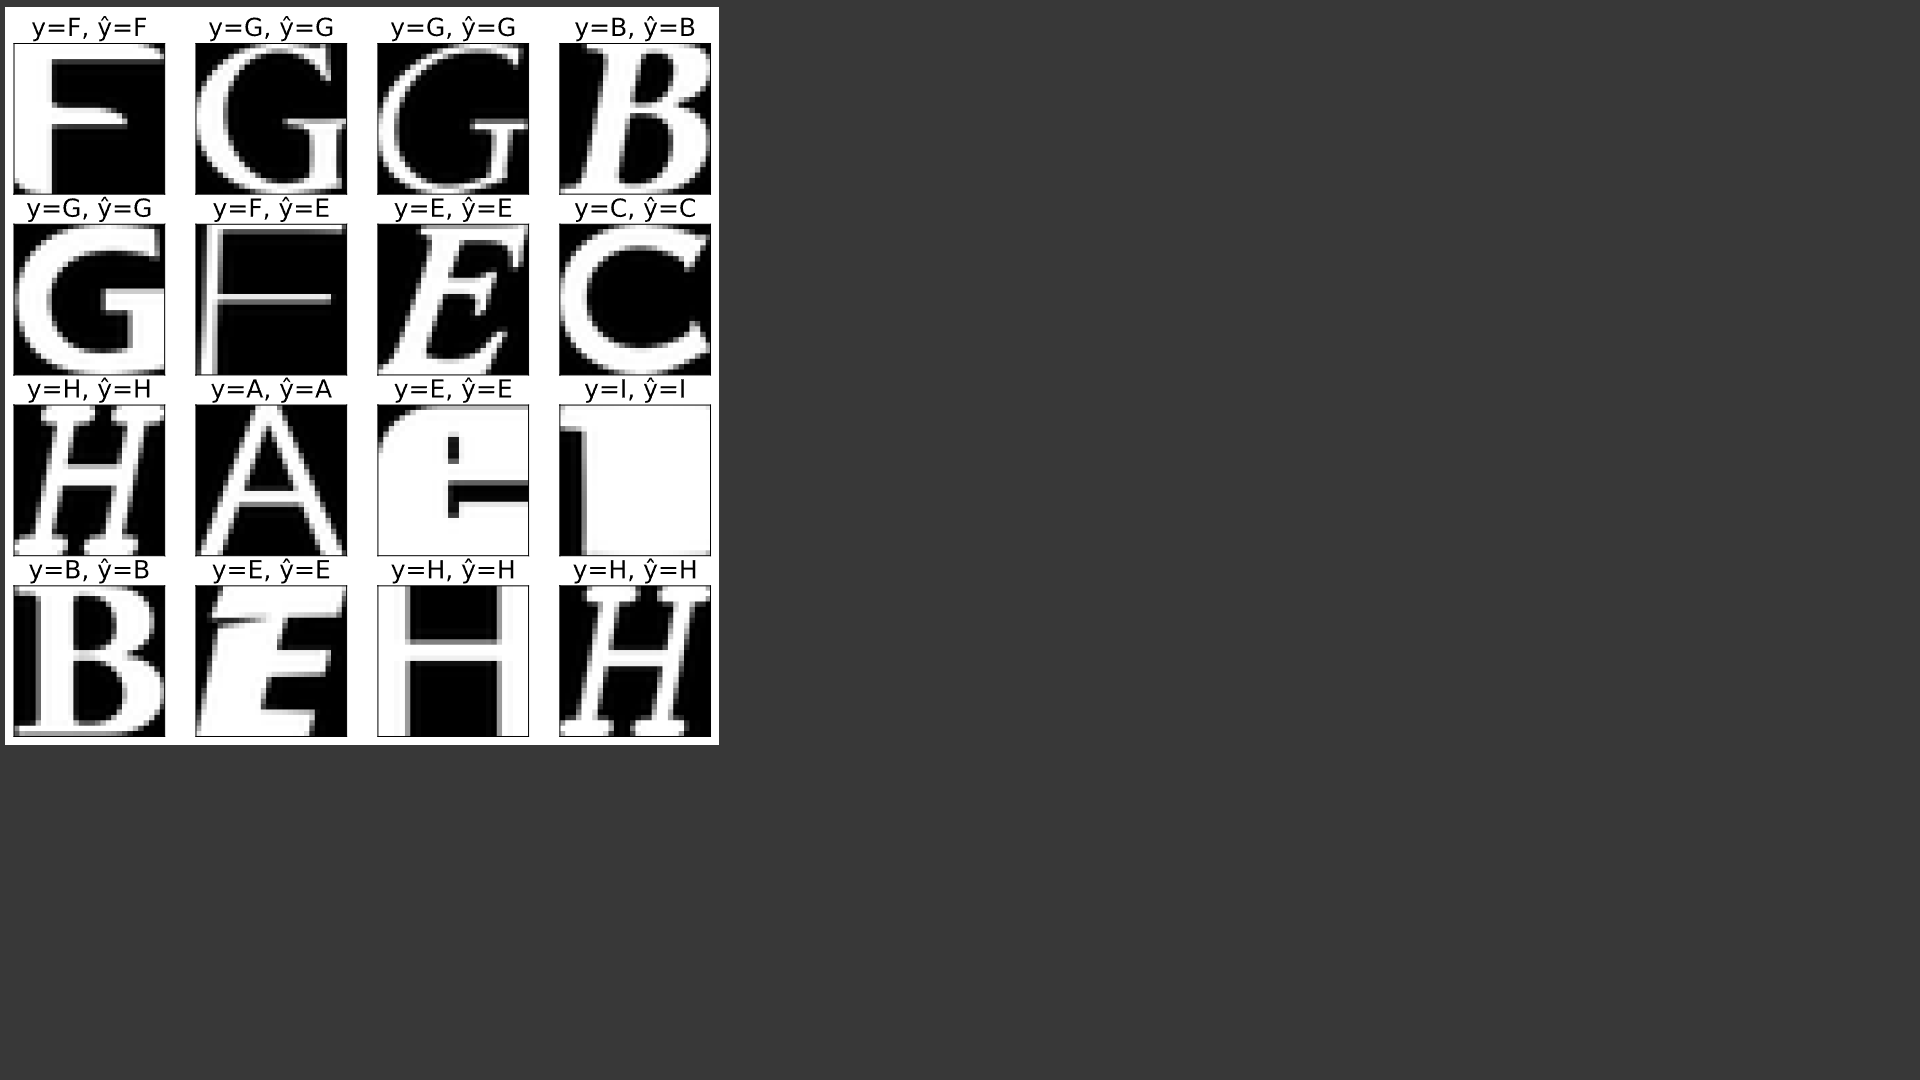

## Plot results